## Import Library

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
from operator import attrgetter
from scipy import stats

## Import CSV

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/online_retail_II.csv", header = 0)
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


## Data Cleansing

In [ ]:
df_resik = df.copy()

# create date columns
df_resik['order_date'] = df_resik['InvoiceDate'].astype('datetime64[ns]')

# convertion datetime
df_resik['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors = 'coerce')

# create month column
df_resik['year_month'] = df_resik['InvoiceDate'].dt.to_period('M')

# Remove all customer id
df_resik = df_resik[~df_resik['Customer ID'].isna()]

# Remove all description
df_resik = df_resik[~df_resik['Description'].isna()]

# Make all item in description column with no capital
df_resik['Description'] = df_resik['Description'].str.lower()

# Remove all name in the row, that name p, w and post
df_resik = df_resik[~df_resik['StockCode'].str.match('^\d+$', case=False, na=False)]

# Adding order status
df_resik['order_status'] = np.where(df_resik['Invoice'].str[:1]=='C', 'Cancelled', 'Delivered')

# change negatif to positif in quantity
df_resik['Quantity'] = df_resik['Quantity'].abs()

# Remove row that there's negative
df_resik = df_resik[df_resik['Price'] > 0]

# Create new column by name amount
df_resik['Amount'] = df_resik['Quantity'] * df_resik['Price']

# Get the most common in description for every stockcode
most_freq_product_name = df_resik.groupby(['StockCode', 'Description'], as_index=False) \
  .agg(order_cnt=('Invoice', 'nunique')).sort_values(['StockCode', 'order_cnt'], ascending=[True, False] )
most_freq_product_name['rank'] = most_freq_product_name.groupby('StockCode')['order_cnt'].rank(method = 'first', ascending=False)
most_freq_product_name = most_freq_product_name[most_freq_product_name['rank'] == 1].drop(columns=['order_cnt', 'rank'])

df_resik = df_resik.merge(
    most_freq_product_name.rename(columns={'Description' : 'most_freq_product_name'}),
    how = 'left',
    on = 'StockCode'
)
df_resik['Description'] = df_resik['most_freq_product_name']
df_resik = df_resik.drop(columns='most_freq_product_name')

# # Change Customer Id to String
df_resik['Customer ID'] = df_resik['Customer ID'].astype('str')

# Outier Remove
df_resik = df_resik[(np.abs(stats.zscore(df_resik[['Quantity', 'Amount']])) < 3).all(axis=1)]
df_resik = df_resik.reset_index(drop=True)
df_resik

/tmp/ipython-input-3-1893614331.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resik['Amount'] = df_resik['Quantity'] * df_resik['Price']


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,order_date,year_month,order_status,Amount
0,489434,79323P,pink cherry lights,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01 07:45:00,2009-12,Delivered,81.00
1,489434,79323W,white cherry lights,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01 07:45:00,2009-12,Delivered,81.00
2,489436,48173C,doormat black flock,10,2009-12-01 09:06:00,5.95,13078.0,United Kingdom,2009-12-01 09:06:00,2009-12,Delivered,59.50
3,489436,35004B,set of 3 black flying ducks,12,2009-12-01 09:06:00,4.65,13078.0,United Kingdom,2009-12-01 09:06:00,2009-12,Delivered,55.80
4,489439,85014A,black/blue polkadot umbrella,3,2009-12-01 09:28:00,5.95,12682.0,France,2009-12-01 09:28:00,2009-12,Delivered,17.85
...,...,...,...,...,...,...,...,...,...,...,...,...
31441,581578,POST,postage,3,2011-12-09 12:16:00,18.00,12713.0,Germany,2011-12-09 12:16:00,2011-12,Delivered,54.00
31442,581578,84997D,pink 3 piece mini dots cutlery set,8,2011-12-09 12:16:00,4.15,12713.0,Germany,2011-12-09 12:16:00,2011-12,Delivered,33.20
31443,581578,84997B,red 3 piece mini dots cutlery set,8,2011-12-09 12:16:00,4.15,12713.0,Germany,2011-12-09 12:16:00,2011-12,Delivered,33.20
31444,581578,84997C,blue 3 piece mini dots cutlery set,8,2011-12-09 12:16:00,4.15,12713.0,Germany,2011-12-09 12:16:00,2011-12,Delivered,33.20


# Create User Retention Cohort

Aggregat Data into a summary transaction every user in a month

In [ ]:
df_user_month = df_resik.groupby(['Customer ID', 'year_month'], as_index=False).agg(order_cnt=('Invoice', 'nunique'))
df_user_month

,Customer ID,year_month,order_cnt
0,12346.0,2009-12,4
1,12346.0,2010-01,5
2,12346.0,2010-03,1
3,12346.0,2010-06,2
4,12346.0,2010-10,1
...,...,...,...
11062,18286.0,2009-12,1
11063,18286.0,2010-06,1
11064,18286.0,2010-08,1
11065,18287.0,2010-05,1


## Create column as cohort from users

In [ ]:
df_user_month['cohort'] = df_user_month.groupby('Customer ID')['year_month'].transform(min)
df_user_month

/tmp/ipython-input-12-1365418326.py:1: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  df_user_month['cohort'] = df_user_month.groupby('Customer ID')['year_month'].transform(min)


,Customer ID,year_month,order_cnt,cohort
0,12346.0,2009-12,4,2009-12
1,12346.0,2010-01,5,2009-12
2,12346.0,2010-03,1,2009-12
3,12346.0,2010-06,2,2009-12
4,12346.0,2010-10,1,2009-12
...,...,...,...,...
11062,18286.0,2009-12,1,2009-12
11063,18286.0,2010-06,1,2009-12
11064,18286.0,2010-08,1,2009-12
11065,18287.0,2010-05,1,2010-05


## calculate the month transaction with month transaction first time and add 1 so that the month distance 0 becomes 1 that means first month

In [ ]:
df_user_month['period'] = (df_user_month['year_month'] - df_user_month['cohort']).apply(attrgetter('n')) + 1
df_user_month

,Customer ID,year_month,order_cnt,cohort,period
0,12346.0,2009-12,4,2009-12,1
1,12346.0,2010-01,5,2009-12,2
2,12346.0,2010-03,1,2009-12,4
3,12346.0,2010-06,2,2009-12,7
4,12346.0,2010-10,1,2009-12,11
...,...,...,...,...,...
11062,18286.0,2009-12,1,2009-12,1
11063,18286.0,2010-06,1,2009-12,7
11064,18286.0,2010-08,1,2009-12,9
11065,18287.0,2010-05,1,2010-05,1


## pivot tables with index have the shape of cohort, column have the sape of month, and the grade is a many unique user




In [ ]:
df_cohort = pd.pivot_table(df_user_month, index='cohort', columns='period', values='Customer ID', aggfunc=pd.Series.nunique)
df_cohort

period,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
cohort,,,,,,,,,,,,,,,,,,,,,
2009-12,608.0,192.0,155.0,193.0,152.0,165.0,172.0,137.0,129.0,143.0,...,87.0,77.0,89.0,90.0,92.0,76.0,93.0,99.0,102.0,45.0
2010-01,285.0,45.0,62.0,53.0,65.0,52.0,46.0,36.0,54.0,65.0,...,18.0,33.0,24.0,30.0,26.0,27.0,27.0,34.0,8.0,NaN
2010-02,241.0,41.0,48.0,48.0,41.0,43.0,34.0,35.0,42.0,42.0,...,21.0,24.0,11.0,14.0,23.0,19.0,21.0,7.0,NaN,NaN
2010-03,287.0,36.0,52.0,45.0,48.0,30.0,36.0,48.0,45.0,17.0,...,17.0,15.0,16.0,19.0,23.0,18.0,10.0,NaN,NaN,NaN
2010-04,187.0,29.0,24.0,22.0,15.0,34.0,31.0,33.0,11.0,14.0,...,10.0,9.0,8.0,21.0,15.0,5.0,NaN,NaN,NaN,NaN
2010-05,174.0,24.0,17.0,16.0,11.0,29.0,20.0,13.0,6.0,14.0,...,10.0,8.0,11.0,9.0,2.0,NaN,NaN,NaN,NaN,NaN
2010-06,176.0,25.0,17.0,20.0,23.0,33.0,9.0,9.0,9.0,6.0,...,9.0,11.0,19.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-07,120.0,14.0,15.0,20.0,21.0,8.0,9.0,8.0,10.0,7.0,...,10.0,15.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,112.0,16.0,20.0,19.0,9.0,2.0,11.0,6.0,5.0,5.0,...,10.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Calculate many user in every cohort

In [ ]:
calculate_cohort = df_cohort.iloc[:,0]
calculate_cohort

,1
cohort,
2009-12,608.0
2010-01,285.0
2010-02,241.0
2010-03,287.0
2010-04,187.0
2010-05,174.0
2010-06,176.0
2010-07,120.0
2010-08,112.0


In [ ]:
df_retention = df_cohort.divide(calculate_cohort, axis=0)
df_retention

period,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
cohort,,,,,,,,,,,,,,,,,,,,,
2009-12,1.0,0.315789,0.254934,0.317434,0.250000,0.271382,0.282895,0.225329,0.212171,0.235197,...,0.143092,0.126645,0.146382,0.148026,0.151316,0.125000,0.152961,0.162829,0.167763,0.074013
2010-01,1.0,0.157895,0.217544,0.185965,0.228070,0.182456,0.161404,0.126316,0.189474,0.228070,...,0.063158,0.115789,0.084211,0.105263,0.091228,0.094737,0.094737,0.119298,0.028070,NaN
2010-02,1.0,0.170124,0.199170,0.199170,0.170124,0.178423,0.141079,0.145228,0.174274,0.174274,...,0.087137,0.099585,0.045643,0.058091,0.095436,0.078838,0.087137,0.029046,NaN,NaN
2010-03,1.0,0.125436,0.181185,0.156794,0.167247,0.104530,0.125436,0.167247,0.156794,0.059233,...,0.059233,0.052265,0.055749,0.066202,0.080139,0.062718,0.034843,NaN,NaN,NaN
2010-04,1.0,0.155080,0.128342,0.117647,0.080214,0.181818,0.165775,0.176471,0.058824,0.074866,...,0.053476,0.048128,0.042781,0.112299,0.080214,0.026738,NaN,NaN,NaN,NaN
2010-05,1.0,0.137931,0.097701,0.091954,0.063218,0.166667,0.114943,0.074713,0.034483,0.080460,...,0.057471,0.045977,0.063218,0.051724,0.011494,NaN,NaN,NaN,NaN,NaN
2010-06,1.0,0.142045,0.096591,0.113636,0.130682,0.187500,0.051136,0.051136,0.051136,0.034091,...,0.051136,0.062500,0.107955,0.005682,NaN,NaN,NaN,NaN,NaN,NaN
2010-07,1.0,0.116667,0.125000,0.166667,0.175000,0.066667,0.075000,0.066667,0.083333,0.058333,...,0.083333,0.125000,0.033333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,1.0,0.142857,0.178571,0.169643,0.080357,0.017857,0.098214,0.053571,0.044643,0.044643,...,0.089286,0.017857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


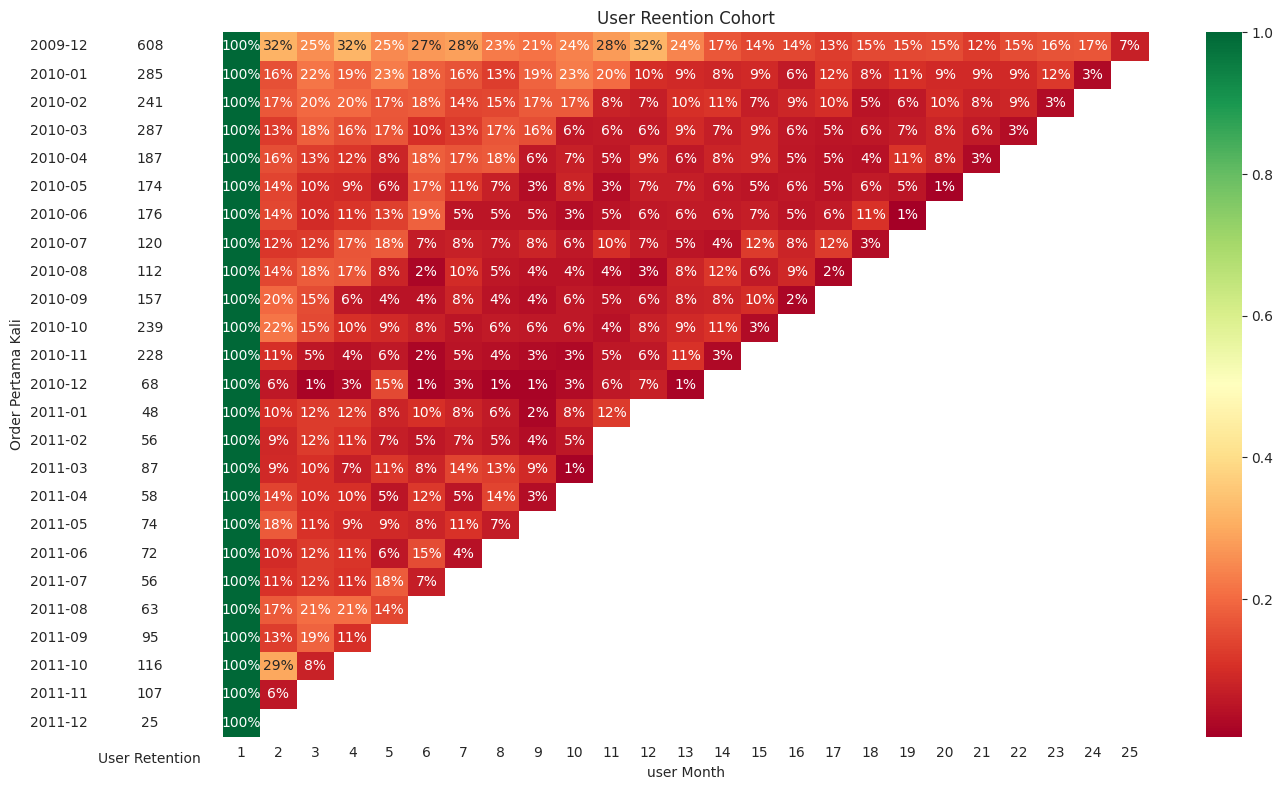

In [ ]:
import matplotlib.colors as mcolors

with sns.axes_style("white") :

  fig, ax = plt.subplots(1, 2, figsize=(14, 8), sharey=True, gridspec_kw={'width_ratios':[1,11]})

  # user retention cohort
  sns.heatmap(df_retention, annot=True, cmap='RdYlGn', fmt='.0%', ax=ax[1])
  ax[1].set_title('User Reention Cohort')
  ax[1].set(xlabel = 'user Month', ylabel = '')

  # cohort size
  df_cohort_size = pd.DataFrame(calculate_cohort)
  white_cmap = mcolors.ListedColormap(['white'])
  sns.heatmap(df_cohort_size, annot=True, cbar=False, fmt='g', cmap=white_cmap, ax=ax[0])
  ax[0].tick_params(bottom=False)
  ax[0].set(xlabel = 'User Retention', ylabel = 'Order Pertama Kali', xticklabels = [])

  fig.tight_layout()